# MNIST Tutorial for basic neural network

In this tutorial, we will implement, train, and evaluate a simple MLP (Multi-Layer Perceptron) neural network to perform the task of hand-written digit recognition. We will use the `autograd` library and do things in a low level way.

## Setup and Workaround for jupyterlite

First run the following to install the packages needed. `pyodide_http` is needed to make reading files work, don't know why. We also import external file.

In [1]:
import micropip
await micropip.install("scipy")
await micropip.install("matplotlib")
await micropip.install("pyodide-http")
await micropip.install("autograd")

In [2]:
import pyodide_http
pyodide_http.patch_all()

### Code to download and process MNIST dataset

Remember to run this.

In [11]:
from __future__ import absolute_import
from __future__ import print_function
import sys
if sys.version < "3":
    from future.standard_library import install_aliases
    install_aliases()

import os
import gzip
import struct
import array
import numpy as np
#from urllib.request import urlretrieve

#def download(url, filename):
#    if not os.path.exists('data'):
#        os.makedirs('data')
#    out_file = os.path.join('data', filename)
#    if not os.path.isfile(out_file):
#        urlretrieve(url, out_file)

dataset_base = "../datasets/mnist"

def mnist():
    base_url = 'https://yann.lecun.com/exdb/mnist/'

    def parse_labels(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data = struct.unpack(">II", fh.read(8))
            return np.array(array.array("B", fh.read()), dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
            return np.array(array.array("B", fh.read()), dtype=np.uint8).reshape(num_data, rows, cols)

    for filename in ['train-images-idx3-ubyte.gz',
                     'train-labels-idx1-ubyte.gz',
                     't10k-images-idx3-ubyte.gz',
                     't10k-labels-idx1-ubyte.gz']:
        pass
    #download(base_url + filename, filename)

    train_images = parse_images(dataset_base + '/train-images-idx3-ubyte.gz')
    train_labels = parse_labels(dataset_base + '/train-labels-idx1-ubyte.gz')
    test_images  = parse_images(dataset_base + '/t10k-images-idx3-ubyte.gz')
    test_labels  = parse_labels(dataset_base + '/t10k-labels-idx1-ubyte.gz')

    return train_images, train_labels, test_images, test_labels


In [15]:
from __future__ import absolute_import
import matplotlib.pyplot as plt
import matplotlib.image

import autograd.numpy as np
import autograd.numpy.random as npr
#import data_mnist

def load_mnist():
    partial_flatten = lambda x : np.reshape(x, (x.shape[0], np.prod(x.shape[1:])))
    one_hot = lambda x, k: np.array(x[:,None] == np.arange(k)[None, :], dtype=int)
    train_images, train_labels, test_images, test_labels = mnist()
    train_images = partial_flatten(train_images) / 255.0
    test_images  = partial_flatten(test_images)  / 255.0
    train_labels = one_hot(train_labels, 10)
    test_labels = one_hot(test_labels, 10)
    N_data = train_images.shape[0]

    return N_data, train_images, train_labels, test_images, test_labels


def plot_images(images, ax, ims_per_row=5, padding=5, digit_dimensions=(28, 28),
                cmap=matplotlib.cm.binary, vmin=None, vmax=None):
    """Images should be a (N_images x pixels) matrix."""
    N_images = images.shape[0]
    N_rows = (N_images - 1) // ims_per_row + 1
    pad_value = np.min(images.ravel())
    concat_images = np.full(((digit_dimensions[0] + padding) * N_rows + padding,
                             (digit_dimensions[1] + padding) * ims_per_row + padding), pad_value)
    for i in range(N_images):
        cur_image = np.reshape(images[i, :], digit_dimensions)
        row_ix = i // ims_per_row
        col_ix = i % ims_per_row
        row_start = padding + (padding + digit_dimensions[0]) * row_ix
        col_start = padding + (padding + digit_dimensions[1]) * col_ix
        concat_images[row_start: row_start + digit_dimensions[0],
                      col_start: col_start + digit_dimensions[1]] = cur_image
    cax = ax.matshow(concat_images, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    return cax

def save_images(images, filename, **kwargs):
    fig = plt.figure(1)
    fig.clf()
    ax = fig.add_subplot(111)
    plot_images(images, ax, **kwargs)
    fig.patch.set_visible(False)
    ax.patch.set_visible(False)
    plt.savefig(filename)


def make_pinwheel(radial_std, tangential_std, num_classes, num_per_class, rate,
                  rs=npr.RandomState(0)):
    """Based on code by Ryan P. Adams."""
    rads = np.linspace(0, 2*np.pi, num_classes, endpoint=False)

    features = rs.randn(num_classes*num_per_class, 2) \
        * np.array([radial_std, tangential_std])
    features[:, 0] += 1
    labels = np.repeat(np.arange(num_classes), num_per_class)

    angles = rads[labels] + rate * np.exp(features[:,0])
    rotations = np.stack([np.cos(angles), -np.sin(angles), np.sin(angles), np.cos(angles)])
    rotations = np.reshape(rotations.T, (-1, 2, 2))

    return np.einsum('ti,tij->tj', features, rotations)


## Defining model and training

The code below implement the MLP model. There are three layers with the input, 2 hidden columns of neurons, followed by the final layer to compute the output.

- Input: flat dimension 784 (`= 28 * 28`) fed the greyscale image
- Hidden layers: dimension 200 and 100 to compute image features
- Output: dimension 10, logits for each label class

As we will see later, logits can be converted to actual probability by the softmax function. But for the purpose of picking the most confident class, we can just pick the label with max logit due to monotonicity.

In [23]:
"""A multi-layer perceptron for classification of MNIST handwritten digits."""
from __future__ import absolute_import, division
from __future__ import print_function
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd.scipy.special import logsumexp
from autograd import grad
from autograd.misc.flatten import flatten
from autograd.misc.optimizers import adam
#from data import load_mnist
import time


def init_random_params(scale, layer_sizes, rs=npr.RandomState(0)):
    """Build a list of (weights, biases) tuples,
       one for each layer in the net."""
    return [(scale * rs.randn(m, n),   # weight matrix
             scale * rs.randn(n))      # bias vector
            for m, n in zip(layer_sizes[:-1], layer_sizes[1:])]

def neural_net_predict(params, inputs):
    """Implements a deep neural network for classification.
       params is a list of (weights, bias) tuples.
       inputs is an (N x D) matrix.
       returns normalized class log-probabilities."""
    for W, b in params:
        outputs = np.dot(inputs, W) + b
        inputs = np.tanh(outputs)
    return outputs - logsumexp(outputs, axis=1, keepdims=True)

def l2_norm(params):
    """Computes l2 norm of params by flattening them into a vector."""
    flattened, _ = flatten(params)
    return np.dot(flattened, flattened)

def log_posterior(params, inputs, targets, L2_reg):
    log_prior = -L2_reg * l2_norm(params)
    log_lik = np.sum(neural_net_predict(params, inputs) * targets)
    return log_prior + log_lik

def accuracy(params, inputs, targets):
    target_class    = np.argmax(targets, axis=1)
    predicted_class = np.argmax(neural_net_predict(params, inputs), axis=1)
    return np.mean(predicted_class == target_class)



# Model parameters
layer_sizes = [784, 200, 100, 10]
L2_reg = 1.0

# Training parameters
param_scale = 0.1
batch_size = 256
num_epochs = 5
step_size = 0.001

print("Loading training data...")
N, train_images, train_labels, test_images,  test_labels = load_mnist()

init_params = init_random_params(param_scale, layer_sizes)

num_batches = int(np.ceil(len(train_images) / batch_size))
def batch_indices(iter):
    idx = iter % num_batches
    return slice(idx * batch_size, (idx+1) * batch_size)

# Define training objective
def objective(params, iter):
    idx = batch_indices(iter)
    return -log_posterior(params, train_images[idx], train_labels[idx], L2_reg)

# Get gradient of objective using autograd.
objective_grad = grad(objective)

global timer_prev
timer_prev = 0
training_logs = {
    "train_acc": [],
    "test_acc": [],
    "elapsed_time": []
}
def print_perf(params, iter, gradient):
    global timer_prev
    if iter % num_batches == 0:
        train_acc = accuracy(params, train_images, train_labels)
        test_acc  = accuracy(params, test_images, test_labels)
        timer_cur = time.time()
        elapsed_time = timer_cur - timer_prev
        timer_prev = timer_cur
        print("{:15}|{:20}|{:20}|{:20}".format(iter//num_batches, train_acc, test_acc, elapsed_time))
        training_logs["train_acc"].append(train_acc)
        training_logs["test_acc"].append(test_acc)
        training_logs["elapsed_time"].append(elapsed_time)


Loading training data...


Now let's train it! It will take some time as running compute in browser via wasm is about 10x slower than running natively, and we don't use GPU.

In [25]:
timer_prev = time.time()
print("     Epoch     |    Train accuracy  |       Test accuracy  ")
# The optimizers provided can optimize lists, tuples, or dicts of parameters.
optimized_params = adam(objective_grad, init_params, step_size=step_size,
                            num_iters=num_epochs * num_batches, callback=print_perf)

     Epoch     |    Train accuracy  |       Test accuracy  
              0| 0.06888333333333334|              0.0657|   15.05400013923645
              1|             0.90525|              0.9105|   44.90299987792969
              2|  0.9107833333333333|              0.9136|   43.98799991607666
              3|  0.9164833333333333|               0.919|   42.91799998283386
              4|  0.9217333333333333|              0.9248|  45.992000102996826


With the training done, let's plot a graph showing how accuracy improved over the epoches.

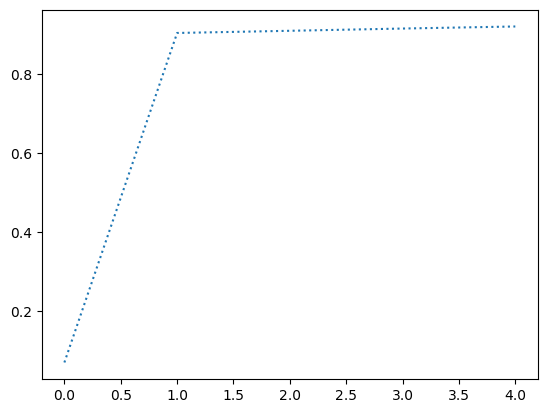

In [26]:
import matplotlib.pyplot as plt
import numpy as nnp

plt.plot(training_logs["train_acc"], linestyle='dotted')
plt.show()

## Saving and loading model

(This section is being worked on with the newer serialization program in later tutorial being back-ported.)

Because the trained params are currently in memory, if we reload the page or restart the kernel it will be gone. To make sure we don't lose the hard work, let's save the params, aka serialize it. We use numpy's serialization utility here.

Notice that `optimized_params` have the format `List[Tuple[numpy.array]]`, where each item in the list correspond to the layers, the tuple represent weights and bias, and each entry is a numpy array.

We also disable pickle to be safe.

In [23]:
for i in range(3):
    for j in range(2):
        part_name = ["weights", "bias"]
        print("Saving Layer {i} ({part}) of tensor shape {shape}".format(i=i, part=part_name[j], shape=str(optimized_params[i][j].shape)))
        with open("/drive/model-{i}-{j}.npy".format(i=i, j=j), "wb") as f:
            np.save(f, optimized_params[i][j], allow_pickle=False)

(784, 200)
(200,)
(200, 100)
(100,)
(100, 10)
(10,)


In [14]:
restored_params = [[None, None]] * 3
for i in range(3):
    for j in range(2):
        part_name = ["weights", "bias"]
        print("Loading Layer {i} ({part}) tensor".format(i=i, part=part_name[j]))
        if i != 0 or j != 0:
            with open("/drive/model-{i}-{j}.npy".format(i=i, j=j), "rb") as f:
                restored_params[i][j] = np.load(f, allow_pickle=False)

Loading Layer 0 (weights) tensor
Loading Layer 0 (bias) tensor
Loading Layer 1 (weights) tensor
Loading Layer 1 (bias) tensor
Loading Layer 2 (weights) tensor
Loading Layer 2 (bias) tensor


In [14]:
optimized_params = restored_params

In [15]:
for i in range(3):
    for j in range(2):
        if i != 0 or j != 0:
            print(restored_params[i][j].shape)

(10,)
(100, 10)
(10,)
(100, 10)
(10,)


In [ ]:
#restored_params[1][0].byteswap().newbyteorder()

In [32]:
import base64
import io

new_restored = {}

for i in range(3):
    for j in range(2):
        with open("model-{i}-{j}-new.txt".format(i=i, j=j), "r") as f:
            mybase = f.read()
            a = io.BytesIO(base64.b64decode(mybase))
            new_restored["layer{i}-{j}".format(i=i, j=j)] = np.load(a, allow_pickle=False)

In [33]:
for i in range(3):
    for j in range(2):
        print(new_restored["layer{i}-{j}".format(i=i, j=j)].shape)

(784, 200)
(200,)
(200, 100)
(100,)
(100, 10)
(10,)


In [37]:
optimized_params = []
for i in range(3):
    tmp = (new_restored["layer{i}-0".format(i=i)], new_restored["layer{i}-1".format(i=i)])
    optimized_params.append(tmp)

In [41]:
optimized_params[1][0].shape

(200, 100)

## Inference

We now write a function that let us do inference on specific instance of the test set.

We also provide code snippet to visualize the image as well as the neural network's predicted probability distribution for each class label. Color is used to highlight the correct label.

In [27]:
def inference_test(params, idx):
    logits = neural_net_predict(params, test_images[idx:idx+1,:])
    predicted = np.argmax(logits)
    actual = np.argmax(test_labels[idx])
    return { "logits": logits, "predicted": predicted, "actual": actual, "correct": predicted == actual }

In [29]:
inference_test(optimized_params, 4173)

{'logits': array([[-6.52719079, -4.61786473, -0.99643756, -3.20247321, -0.94570821,
         -4.77741586, -2.21237464, -7.95289054, -2.74644903, -4.82336449]]),
 'predicted': 4,
 'actual': 2,
 'correct': False}

In [30]:
import numpy as nnp
def softmax(x):
    e_x = nnp.exp(x - nnp.max(x))
    return e_x / e_x.sum()

softmax(inference_test(optimized_params, 1263)["logits"][0])

array([6.26956889e-05, 5.74115380e-03, 1.83833859e-02, 1.54688738e-02,
       6.70705926e-01, 5.74568821e-05, 2.33160498e-03, 1.02720215e-01,
       3.13575312e-03, 1.81392934e-01])

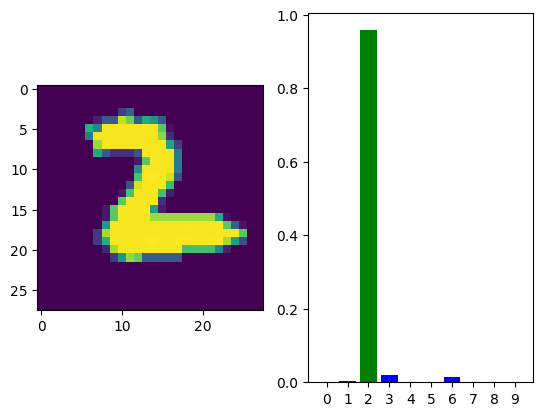

In [34]:
import matplotlib.pyplot as plt

idx = 4204
results = inference_test(optimized_params, idx)
c = ["blue"] * 10
c[results["actual"]] = "green"
if not results["correct"]:
    c[results["predicted"]] = "red"    
cur_image = test_images[idx].reshape(28, 28)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.imshow(cur_image, interpolation='none')
ax2.bar([str(x) for x in range(10)], softmax(results["logits"][0]), color=c)
plt.show()